In [12]:
from google.colab import files
uploaded = files.upload()

Saving classification_clustering_data_py.py to classification_clustering_data_py (1).py


## クラスタリング<br>

「似ているデータどうしを自動でグループに分けること」<br>

ラベル（正解）がないデータを対象に、特徴の近さ（距離など）を使って、似ている仲間を探してグループ（＝クラスタ）を作る手法

【初期状態のクラスタ】
[0 3 1 0 3 3 3 3 1 3 1 2 0 3 2 0 0 0 2 1 2 3 3 2 0 1 1 1 1 0 1 0 3 0 3 1 2
 3 3 0 2 3 0 1 3 1 3 3 2 3 0 1 1 1 3 0 3 2 0 3 3 2 3 2 3 0 2 0 0 0 1 1 2 0
 0 1 3 0 1 2 2 3 0 1 1 3 1 1 3 2 3 3 2 2 3 0 2 3 1 0 1 2 0 3 0 2 0 3 3 0 3
 0 0 0 0 2 3 0 3 2 3 3 1 1 1 0 1 1 1 3 0 3 1 2 0 1 2 0 2 0 1 3 2 2 1 0 3 1
 1 3 0 2 2 3 2 3 3 3 2 1 2 2 3 2 3 3 2 2 3 0 1 2 3 2 1 2 1 0 2 2 3 0 3 2 3
 0 0 2 0 2 3 2 2 3 0 0 0 1 2 0]
1回目の繰り返しを始めます
【重心】
[[25.76470588 41.19607843]
 [34.02380952 32.52380952]
 [30.97916667 41.02083333]
 [28.27118644 41.45762712]]
【計算し直したクラスタ】
[1 1 2 0 1 2 0 1 2 2 2 1 0 0 1 2 0 0 0 1 0 0 1 0 1 1 3 1 1 2 0 2 0 1 0 2 0
 2 2 0 0 0 0 1 1 0 1 0 0 2 0 0 0 0 1 0 0 1 3 1 0 2 1 2 0 2 1 0 0 0 1 1 1 1
 0 0 0 0 1 1 0 2 1 1 0 2 1 1 0 0 0 0 0 3 2 1 0 0 1 2 0 1 1 0 0 0 2 1 1 2 0
 0 0 1 1 2 1 0 0 1 0 1 2 1 1 0 1 0 1 2 0 1 1 0 0 0 3 0 1 0 1 0 1 1 1 1 2 1
 0 0 0 0 1 0 1 2 0 0 0 1 0 1 1 0 0 3 1 1 1 0 1 1 0 3 0 0 2 2 0 0 1 1 2 1 2
 0 0 0 2 0 1 1 2 0 0 0 0 2 0 1]
2回目の繰り返しを始めます
【重心】
[[13.65555556 

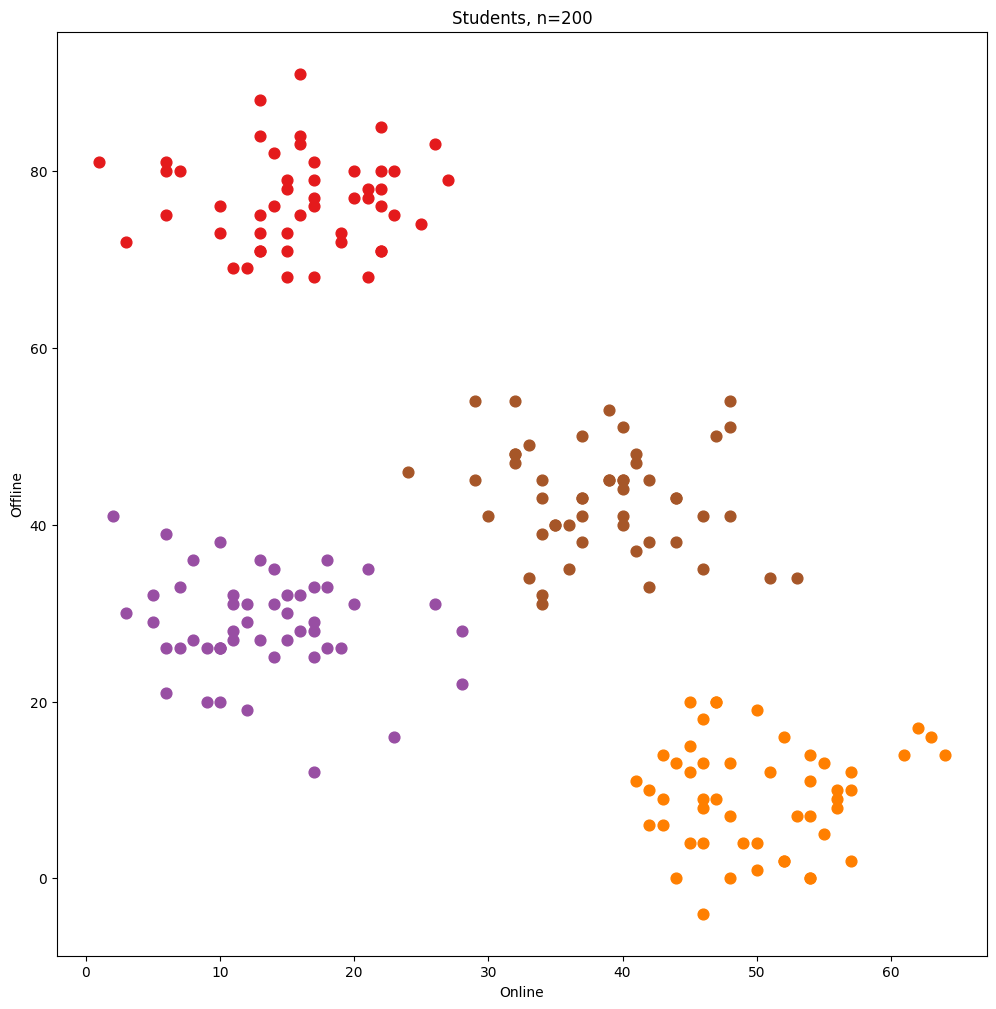

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from classification_clustering_data import * # 外部ファイルからデータ読込

クラスタ数=4
最大繰り返し数=100
クラスタ毎の色=['#984ea3','#ff7f00','#a65628','#e41a1c']

'''
１．ユークリッド距離を計算
目的：2つの点（XY座標）の**直線距離（＝ユークリッド距離）**を計算

 例：
点1 = [3, 4]
点2 = [0, 0]
→ √((3-0)^2 + (4-0)^2) = √(9 + 16) = √25 = 5
'''
def ユークリッド距離を計算(点1のXY,点2のXY): # ピタゴラスの定理で計算
    return np.sqrt((点2のXY[0]-点1のXY[0])**2 + (点2のXY[1]-点1のXY[1])**2)

'''
２．クラスタ毎の重心を計算
目的：各クラスタに属している点を集めて、**その平均位置（＝重心）**を求める
流れ：クラスタ0に属する点が3つ → その3点の「xとyの平均値」を1つの点として計算
出力：クラスタ数 × 2 の配列（各クラスタの [x, y]）

-----「クラスタ毎の重心を計算」-----
・重心とは→**点の集まりの中で、真ん中にある点（平均値）**のこと
・クラスタ0に以下の３人の学生がいる場合
→学生A オンライン時時間(X):10  オフライン時間(y)：20
→学生B オンライン時時間(X):20  オフライン時間(y)：30
→学生C オンライン時時間(X):30  オフライン時間(y)：	40
・このときのクラスタ0の重心は：
  xの平均 = (10 + 20 + 30) / 3 = 20
  yの平均 = (20 + 30 + 40) / 3 = 30
  → 重心 = [20, 30]

'''
def クラスタ毎の重心を計算(点の配列,クラスタの配列):
    返す配列 = np.empty((0,2)) # 空っぽの2次元配列を作る
    for クラスタ番号 in range(クラスタ数):
        重心のXY = 点の配列[クラスタの配列 == クラスタ番号].mean(axis=0) # 行方向、すなわち列ごとの平均
        返す配列=np.append(返す配列,np.array([重心のXY]),axis=0) # axis=0で行追加(axis=1なら列追加)
    return 返す配列 # 確定した2次元配列を返す


'''
３.各点から最短距離の重心を調べる
目的：
・各点が「どの重心に一番近いか」を調べて、**所属するクラスタ番号（0〜3）**を決定する
流れ：
１．点を1つ選ぶ
２.全ての重心との距離を計算
３.一番近い重心の番号を返す

-----「各点から最短距離の重心を調べる」処理-----
たくさんの点（生徒）と、いくつかの重心（クラスタの中心）があるとき、
それぞれの点が「どの重心に一番近いか？」を調べて、どのクラスタに属するかを決める処理
'''
def 各点から最短距離の重心を調べる(点の配列,重心の配列):
    返す配列 = np.empty(0,int) # 空っぽの配列を作る
    for 点 in 点の配列: # 全ての点について繰り返し
        距離の配列 = np.empty(0) # 空っぽの配列を作る
        for 重心 in 重心の配列: # ある点から、全ての重心に向けて距離を計算していく
            距離の配列 = np.append(距離の配列,ユークリッド距離を計算(点, 重心))
        返す配列 = np.append(返す配列,距離の配列.argmin()) # 距離の配列の中の、最小値の所の番号
    return 返す配列

'''
４．STUDENTS（生徒のデータ）を、重心と距離を使って4つのクラスタに分けていく処理

-----手順-----
①初期化：学生データをランダムに４つのクラスタ(0～3)に割り当てる
②重心の計算：各クラスタに属する生徒の「平均位置（x, y）」＝重心 を求める
③ 割り直し：各生徒が「どの重心に一番近いか？」を調べ、最も近いクラスタに変更する
④判定：全員のクラスタが前回と同じか確認（変わってなければ終了）
⑤繰り返し：変わっていれば②に戻る（最大100回まで）
'''
def k_meansでクラスタリング():
    #初期クラスタのランダム割り当て
    #ランダムにクラスタ番号（0〜3）を各生徒に割り当てる
    # len(STUDENTS)=200 なら、200人分の [2, 0, 3, 1, ...] みたいな配列が作成
    #np.random.seed(0) は毎回同じ結果を得るための設定（再現性のため）
    np.random.seed(0)
    暫定版クラスタの配列 = np.random.randint(0, クラスタ数, len(STUDENTS)) # 初期状態はランダム

    print("【初期状態のクラスタ】\n"+ str(暫定版クラスタの配列))

    #クラスタ更新の繰り返し（最大100回）
    #クラスタを何度も再計算していくループ（上限は100回）
    for 繰り返し回数 in range(最大繰り返し数):
            print(str(繰り返し回数+1) + "回目の繰り返しを始めます")

            #今のクラスタ割り当てに基づいて、各クラスタの重心（中心点）を計算
            暫定版重心の配列 = クラスタ毎の重心を計算(STUDENTS,暫定版クラスタの配列)
            print("【重心】\n"+ str(暫定版重心の配列))
            #各生徒がどの重心に一番近いかを調べて、再度クラスタ番号を決定
            更新されるクラスタの配列 = 各点から最短距離の重心を調べる(STUDENTS,暫定版重心の配列)
            print("【計算し直したクラスタ】\n"+ str(更新されるクラスタの配列))
            #新しく計算したクラスタと前回のクラスタが完全に同じなら終了
            if((更新されるクラスタの配列 == 暫定版クラスタの配列).all()==True):
                break
            #また次のループで重心計算 → 再分類が続く
            暫定版クラスタの配列 = 更新されるクラスタの配列
    return 暫定版クラスタの配列 # 繰り返し終了し、最終結果を返す

def 経過または結果を図示(点の配列,クラスタの配列,色の配列):
    plt.figure(figsize=(12, 12))
    plt.title("Students, n=200")
    plt.xlabel("Online")
    plt.ylabel("Offline")
    for i in range(クラスタ数):
        図示するデータ = 点の配列[クラスタの配列 == i]
        plt.scatter(図示するデータ[:, 0], 図示するデータ[:, 1],c=色の配列[i],s=60)
    plt.show()

########## これよりメイン処理 ##########
#print(STUDENTS) # 全受講者のデータを表示
クラスタリング結果 = k_meansでクラスタリング()
print("【クラスタリング結果】\n"+ str(クラスタリング結果))

経過または結果を図示(STUDENTS,クラスタリング結果,クラスタ毎の色)